Analyzing Training Dataset...
Training Dataset Class Counts: {'0_normal': 800, '2_polyps': 800, '3_esophagitis': 800, '1_ulcerative_colitis': 800}

Analyzing Validation Dataset...
Validation Dataset Class Counts: {'0_normal': 500, '2_polyps': 500, '3_esophagitis': 500, '1_ulcerative_colitis': 500}

Analyzing Test Dataset...
Test Dataset Class Counts: {'0_normal': 200, '2_polyps': 200, '3_esophagitis': 200, '1_ulcerative_colitis': 200}

Displaying Sample Images from Training Dataset...
Class: 0_normal


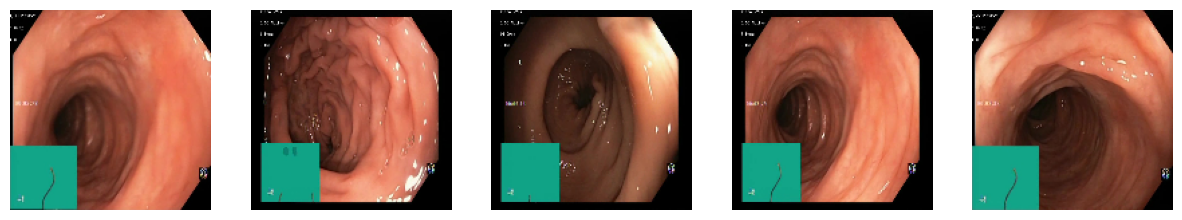

Class: 2_polyps


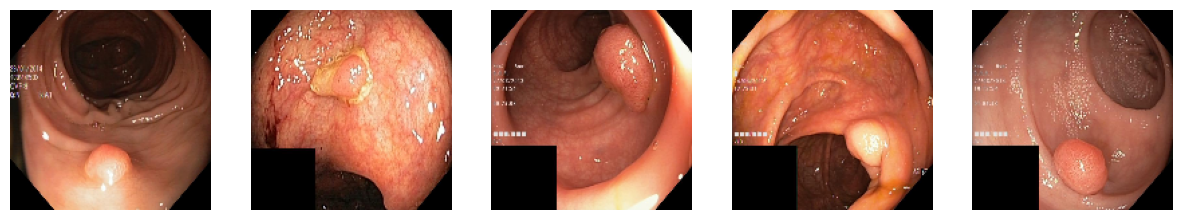

Class: 3_esophagitis


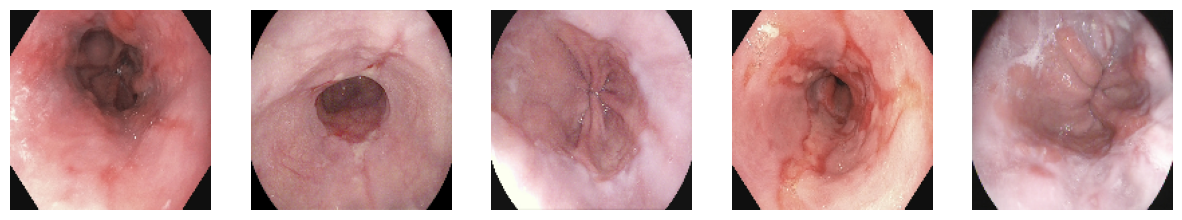

Class: 1_ulcerative_colitis


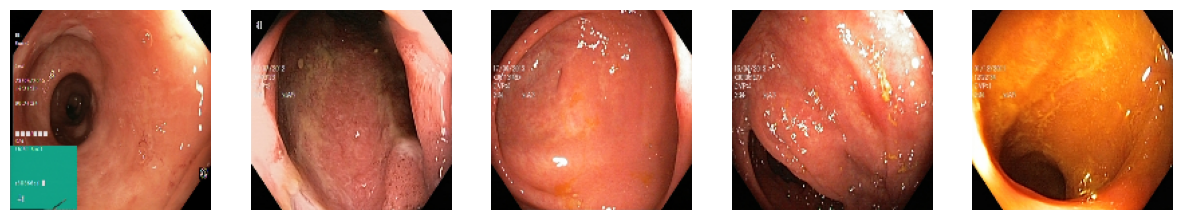

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# ------ Analyze Dataset Structure ------
def analyze_dataset_structure(directory):
    """
    Analyze the dataset structure and count images in each class.
    """
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            image_count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))])
            class_counts[class_name] = image_count
    return class_counts

# ------ Display Sample Images ------
def display_sample_images(directory, num_samples=5, target_size=(150, 150)):
    """
    Display sample images from each class in the dataset.
    """
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            print(f"Class: {class_name}")
            sample_images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))][:num_samples]
            plt.figure(figsize=(15, 5))
            for i, img_file in enumerate(sample_images):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, target_size)  # Resize to target size
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()

# ------ Main Function ------
def main():
    # Dataset directories
    train_dir = '/kaggle/input/curated-colon-dataset-for-deep-learning/train'
    val_dir = '/kaggle/input/curated-colon-dataset-for-deep-learning/val'
    test_dir = '/kaggle/input/curated-colon-dataset-for-deep-learning/test'

    # Analyze train dataset structure
    print("Analyzing Training Dataset...")
    train_class_counts = analyze_dataset_structure(train_dir)
    print("Training Dataset Class Counts:", train_class_counts)

    # Analyze validation dataset structure
    print("\nAnalyzing Validation Dataset...")
    val_class_counts = analyze_dataset_structure(val_dir)
    print("Validation Dataset Class Counts:", val_class_counts)

    # Analyze test dataset structure
    print("\nAnalyzing Test Dataset...")
    test_class_counts = analyze_dataset_structure(test_dir)
    print("Test Dataset Class Counts:", test_class_counts)

    # Display sample images from training dataset
    print("\nDisplaying Sample Images from Training Dataset...")
    display_sample_images(train_dir)

if __name__ == "__main__":
    main()


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# ------ Data Loading & Preprocessing ------
def load_and_preprocess_data(directory, target_size=(224, 224)):
    """
    Load images and preprocess them (resize and normalize).
    """
    images, labels = [], []
    class_mapping = {
        '0_normal': 0,
        '1_ulcerative_colitis': 1,
        '2_polyps': 2,
        '3_esophagitis': 3
    }
    
    for class_name, label in class_mapping.items():
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_file))
            img = cv2.resize(img, target_size)
            img = img / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
            labels.append(label)
    
    return np.array(images), tf.keras.utils.to_categorical(labels)  # One-hot encode labels

# Load datasets
train_dir = '/kaggle/input/curated-colon-dataset-for-deep-learning/train'
val_dir = '/kaggle/input/curated-colon-dataset-for-deep-learning/val'
test_dir = '/kaggle/input/curated-colon-dataset-for-deep-learning/test'

X_train, y_train = load_and_preprocess_data(train_dir)
X_val, y_val = load_and_preprocess_data(val_dir)
X_test, y_test = load_and_preprocess_data(test_dir)

In [4]:
# ------ Data Augmentation ------
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [5]:
# ------ Model Architecture ------
def create_bir_model():
    """
    Create the BIR model architecture based on the research paper.
    """
    base_model = MobileNet(
        input_shape=(224, 224, 3), 
        include_top=False,
        weights='imagenet'
    )
    
    model = Sequential([
        base_model,
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(axis=-1),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(4, activation='softmax')  # Multi-class output layer (4 classes)
    ])
    
    return model

bir_model = create_bir_model()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# ------ Training Configuration ------
bir_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [7]:
# ------ Training Process ------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = bir_model.fit(
    train_generator,
    steps_per_epoch=train_generator.__len__(),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 369ms/step - accuracy: 0.6999 - loss: 8.1016 - val_accuracy: 0.8495 - val_loss: 5.1916 - learning_rate: 0.0010
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8495 - val_loss: 5.1916 - learning_rate: 0.0010
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 294ms/step - accuracy: 0.9450 - loss: 4.0114 - val_accuracy: 0.9410 - val_loss: 2.2395 - learning_rate: 0.0010
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9410 - val_loss: 2.2395 - learning_rate: 0.0010
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 294ms/step - accuracy: 0.9706 - loss: 1.7787 - val_accuracy: 0.9570 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9570 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 294ms/step - accuracy: 0.9735 - loss: 0.7973 - val_accuracy: 0.9410 - val_loss: 0.5861 - learning_rate: 0.0010
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy

In [8]:
# ------ Evaluation ------
y_pred = bir_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.97      0.97      0.97       200
           2       0.97      0.96      0.96       200
           3       1.00      1.00      1.00       200

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



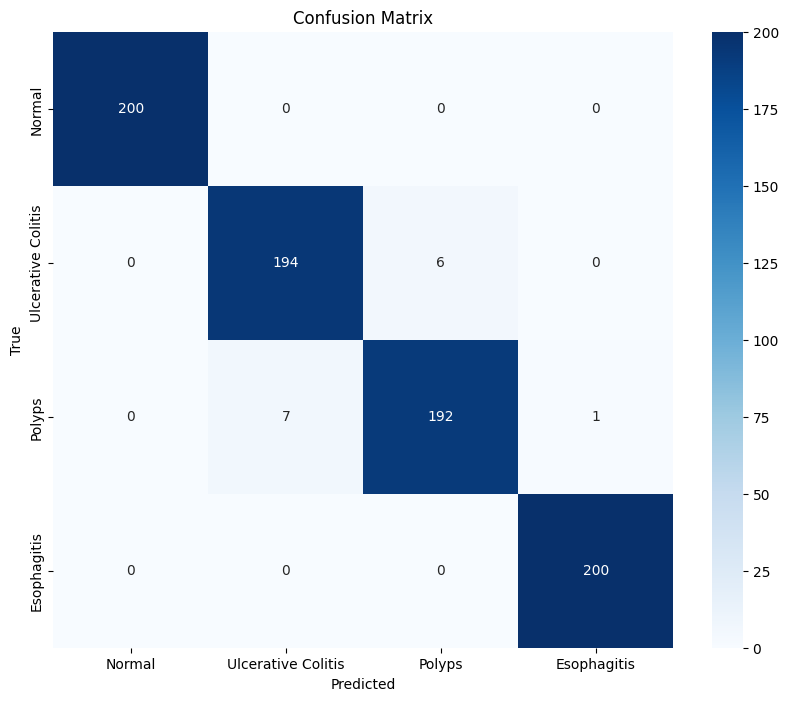

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Ulcerative Colitis', 'Polyps', 'Esophagitis'],
            yticklabels=['Normal', 'Ulcerative Colitis', 'Polyps', 'Esophagitis'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
# Cohen's Kappa Score
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)
print(f"Cohen's Kappa: {kappa:.3f}")


Cohen's Kappa: 0.977


In [11]:
# ------ Machine Learning Models with Cross-Validation ------
y_train_classes = np.argmax(y_train, axis=1)  # Convert one-hot encoded labels to class labels

models = {
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=300, random_state=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=300),
    'Logistic Regression': LogisticRegression(solver='liblinear', multi_class='ovr'),
    'SVM': SVC(kernel='linear', C=2.0)
}

cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train.reshape(len(X_train), -1), y_train_classes, cv=10)
    cv_results[model_name] = scores
    print(f"{model_name} Average Accuracy: {np.mean(scores):.4f}")

Random Forest Average Accuracy: 0.9938
Decision Tree Average Accuracy: 0.9856
Logistic Regression Average Accuracy: 0.9938
SVM Average Accuracy: 0.9944


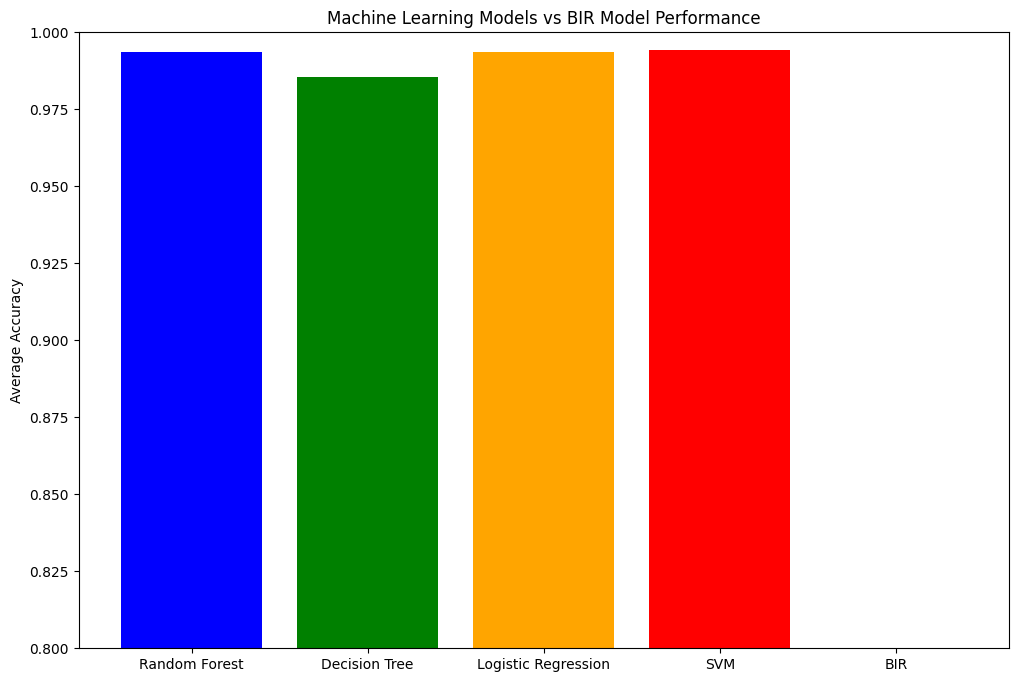

In [12]:
# ------ Graphs for Performance Comparisons ------
# Machine Learning Models vs BIR Model (10-Fold CV)
average_accuracies = {model: np.mean(scores) for model, scores in cv_results.items()}
average_accuracies['BIR'] = np.mean(history.history['accuracy'])

plt.figure(figsize=(12, 8))
plt.bar(average_accuracies.keys(), average_accuracies.values(), color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Machine Learning Models vs BIR Model Performance')
plt.ylabel('Average Accuracy')
plt.ylim(0.8, 1.0)
plt.show()


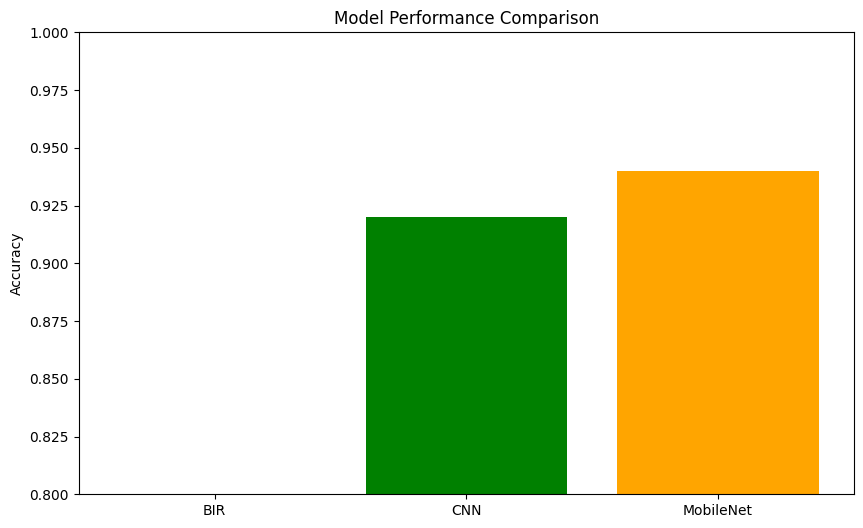

In [13]:
# BIR vs CNN vs MobileNet Comparison
model_accuracies = {
    'BIR': np.mean(history.history['accuracy']),
    'CNN': 0.92,
    'MobileNet': 0.94
}

plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color=['blue', 'green', 'orange'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.show()

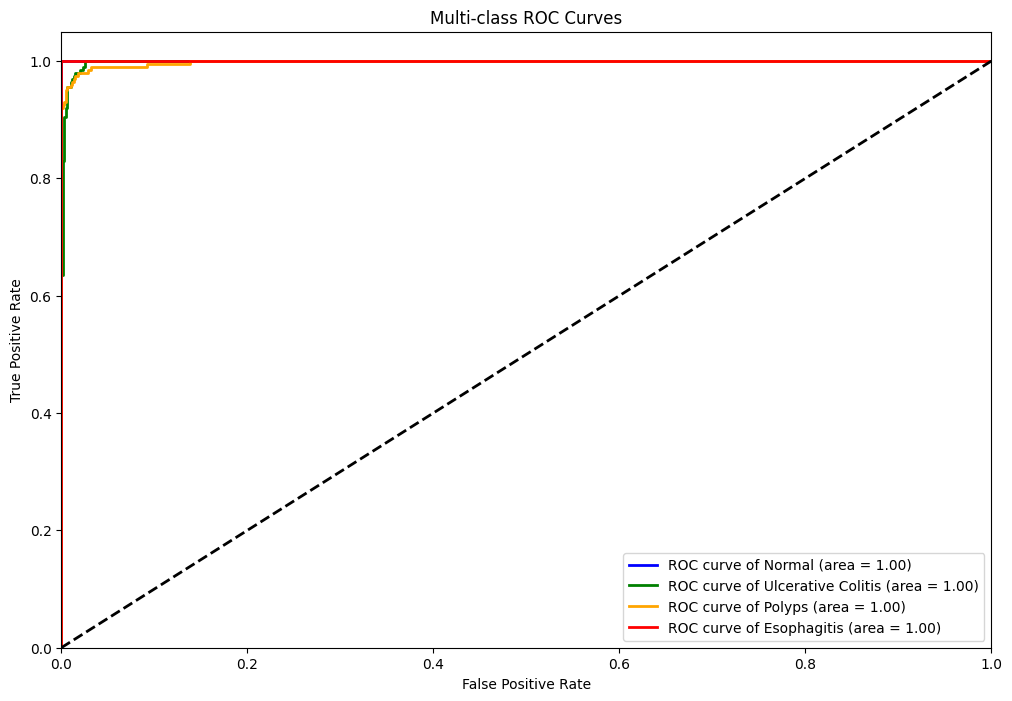


AUC Values:
Normal: 1.0000
Ulcerative Colitis: 0.9983
Polyps: 0.9980
Esophagitis: 1.0000
Micro-average AUC: 0.9995


In [14]:
from sklearn.metrics import roc_curve, auc

# ------ ROC Curve and AUC for Multi-Class ------
n_classes = y_test.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'orange', 'red']
class_names = ['Normal', 'Ulcerative Colitis', 'Polyps', 'Esophagitis']

for i, color, cls in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {cls} (area = {roc_auc[i]:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Print AUC values for each class
print("\nAUC Values:")
for i, cls in enumerate(class_names):
    print(f"{cls}: {roc_auc[i]:.4f}")

# Calculate micro-average ROC curve and AUC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
